In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import datasets
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from tabulate import tabulate
import time
import matplotlib.pyplot as plt
import concurrent.futures
from IPython.display import display, HTML
import random

Load the cancer dataset

In [24]:
wine = datasets.load_wine()
X = wine.data
y = wine.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
feature_names = wine.feature_names
num_features = len(feature_names)
print("Number of features in the Wine dataset:", num_features)

Number of features in the Wine dataset: 13


Initialize the population randomly

In [26]:
population =  np.random.randint(2, size=(5,10))
print(population)

[[0 1 0 0 1 0 0 0 1 0]
 [1 0 1 1 0 1 1 1 0 0]
 [0 0 1 1 0 1 0 0 0 1]
 [1 1 1 0 0 1 1 0 0 0]
 [1 0 0 0 0 1 0 0 1 0]]


Fitness

In [27]:
def fitness_function(individual):
    X_train_subset = X_train[:, individual]
    X_test_subset = X_test[:, individual]
    classifier =  RandomForestClassifier(random_state=42)
    classifier.fit(X_train_subset, y_train)
    y_pred = classifier.predict(X_test_subset)
    reversed_accuracy = 1 - accuracy_score(y_test, y_pred)
    return reversed_accuracy

Get the best features

In [28]:
def run_evolutionary_algorithm(seed):
    #Ensures that each run of the evolutionary algorithm starts with the same initial random state
    np.random.seed(seed)

    #Genetic Algorithm parameters
    population_size = 10
    num_generations = 5
    mutation_rate = 0.01
    num_genes = X.shape[1]

    population =  np.random.randint(2, size=(population_size,X.shape[1]))

    generation_list = []
    best_fitness_list = []
    best_features_list = []


    for generation in range(num_generations):
        
        fitness_values = [fitness_function(individual) for individual in population]
        
        best_index = np.argmin(fitness_values)
        generation_list.append(generation + 1)
        best_fitness_list.append(fitness_values[best_index])
        best_features_list.append(population[best_index])

        selected_indices = np.argsort(fitness_values)
        selected_population = [population[i] for i in selected_indices]

        offspring_population = []
        for i in range(0, len(selected_population) - 1, 2):
            parent1 = selected_population[i]
            parent2 = selected_population[i + 1]
            crossover_point = np.random.randint(1, num_genes)
            offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            offspring_population.extend([offspring1, offspring2])

        offspring_population = np.array(offspring_population)

        for i in range(len(offspring_population)):
            for j in range(num_genes):
                if np.random.rand() < mutation_rate:
                    offspring_population[i, j] = 1 - offspring_population[i, j]

        combined_population = np.vstack([selected_population, offspring_population])
        next_generation_indices = np.argsort([fitness_function(individual) for individual in combined_population])[:population_size]
        population = [combined_population[i] for i in next_generation_indices]

    best_features = population[np.argmin([fitness_function(individual) for individual in population])]
    return generation_list, best_fitness_list, best_features

Run multible Times

In [29]:
# Number of runs for the evolutionary algorithm
num_runs = 5

# List to store data for each run
all_generation_data = []
bestfitness=[]

# Run the evolutionary algorithm in parallel using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Generate seeds for each run
    seeds = range(num_runs)

    # Execute the evolutionary algorithm for each seed and collect results
    results = list(executor.map(run_evolutionary_algorithm, seeds))
        
    # Process and store data for each run
    for result in results:
        generation_data = {"generation_list": result[0], "best_fitness_list": result[1], "best_features": result[2]}
        all_generation_data.append(generation_data)
        newdata  = {"best_fitness_list": min(result[1]), "best_features": result[2]}
        bestfitness.append(newdata)

In [ ]:
best_result = min(bestfitness, key=lambda x: x['best_fitness_list'])
best_features_overall = best_result["best_features"]

Plot the graph for each run and the overall best features

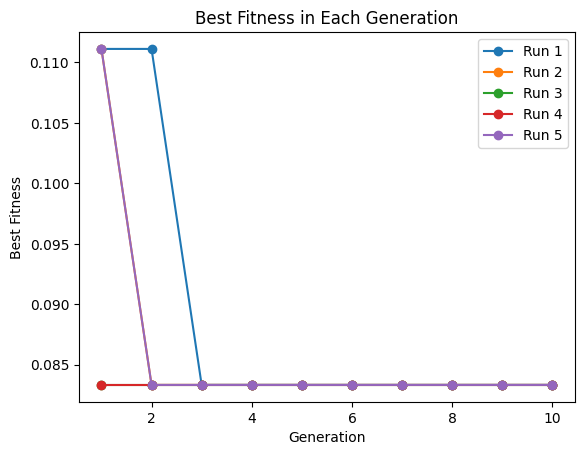

Best Features Overall (Binary Representation): [0 1 0 1 1 1 1 0 0 1 0 0 1]
Fitness of Best Features Overall: 0.08333333333333337


In [30]:
# Plot the graph for each run
for run, data in enumerate(all_generation_data, start=1):
    plt.plot(data["generation_list"], data["best_fitness_list"], marker='o', label=f'Run {run}')

# Set plot properties
plt.title('Best Fitness in Each Generation')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.legend()
    
# Show the plot
plt.show()

# Print the overall best features
print("Best Features Overall (Binary Representation):", best_features_overall[2])
print("Fitness of Best Features Overall:", fitness_function(best_features_overall[2]))

In [31]:
X_train_subset = X_train[:, best_features_overall.astype(bool)]
X_test_subset = X_test[:, best_features_overall.astype(bool)]
random_state = random.randint(1, 50)

Random Forest

In [32]:
start_time_after_rf = time.time()

clf_after_rf = RandomForestClassifier(random_state=random_state)
clf_after_rf.fit(X_train_subset, y_train)
y_pred_after_rf = clf_after_rf.predict(X_test_subset)
accuracy_after_rf = accuracy_score(y_test, y_pred_after_rf)

end_time_after_rf = time.time()
time_taken_after_rf = end_time_after_rf - start_time_after_rf

start_time_before_rf = time.time()

clf_before_rf = RandomForestClassifier(random_state=random_state)
clf_before_rf.fit(X_train, y_train)
y_pred_before_rf = clf_before_rf.predict(X_test)
accuracy_before_rf = accuracy_score(y_test, y_pred_before_rf)

end_time_before_rf = time.time()
time_taken_before_rf = end_time_before_rf - start_time_before_rf

K-Nearest Neighbors Classifier

In [33]:
start_time_after_knn = time.time()

clf_after_knn = KNeighborsClassifier()
clf_after_knn.fit(X_train_subset, y_train)
y_pred_after_knn = clf_after_knn.predict(X_test_subset)
accuracy_after_knn = accuracy_score(y_test, y_pred_after_knn)

end_time_after_knn = time.time()
time_taken_after_knn = end_time_after_knn - start_time_after_knn

start_time_before_knn = time.time()

clf_before_knn = KNeighborsClassifier()
clf_before_knn.fit(X_train, y_train)
y_pred_before_knn = clf_before_knn.predict(X_test)
accuracy_before_knn = accuracy_score(y_test, y_pred_before_knn)

end_time_before_knn = time.time()
time_taken_before_knn = end_time_before_knn - start_time_before_knn


Support Vector Machine Classifier

In [34]:
start_time_after_svm = time.time()

clf_after_svm = SVC(kernel='linear', C=1.0, random_state=random_state)
clf_after_svm.fit(X_train_subset, y_train)
y_pred_after_svm = clf_after_svm.predict(X_test_subset)
accuracy_after_svm = accuracy_score(y_test, y_pred_after_svm)

end_time_after_svm = time.time()
time_taken_after_svm = end_time_after_svm - start_time_after_svm

start_time_before_svm = time.time()

clf_before_svm = SVC(kernel='linear', C=1.0, random_state=random_state)
clf_before_svm.fit(X_train, y_train)
y_pred_before_svm = clf_before_svm.predict(X_test)
accuracy_before_svm = accuracy_score(y_test, y_pred_before_svm)

end_time_before_svm = time.time()
time_taken_before_svm = end_time_before_svm - start_time_before_svm

Logistic Regression

In [35]:
start_time_after_lr = time.time()
clf_after_lr = LogisticRegression(solver='liblinear', random_state=random_state)
clf_after_lr.fit(X_train_subset, y_train)
y_pred_after_lr = clf_after_lr.predict(X_test_subset)
accuracy_after_lr = accuracy_score(y_test, y_pred_after_lr)
end_time_after_lr = time.time()
time_taken_after_lr = end_time_after_lr - start_time_after_lr

start_time_before_lr = time.time()
clf_before_lr = LogisticRegression(solver='liblinear', random_state=random_state)
clf_before_lr.fit(X_train, y_train)
y_pred_before_lr = clf_before_lr.predict(X_test)
accuracy_before_lr = accuracy_score(y_test, y_pred_before_lr)
end_time_before_lr = time.time()
time_taken_before_lr = end_time_before_lr - start_time_before_lr

Results

In [36]:
table = [
    ["Random Forest", "Before Feature Selection", f"{accuracy_before_rf:.4f}", f"{time_taken_before_rf:.4f} seconds"],
    ["Random Forest", "After Feature Selection", f"{accuracy_after_rf:.4f}", f"{time_taken_after_rf:.4f} seconds"],
    ["-" * 20, "-" * 25, "-" * 13, "-" * 18],  # Line between Random Forest and KNN
    ["KNN", "Before Feature Selection", f"{accuracy_before_knn:.4f}", f"{time_taken_before_knn:.4f} seconds"],
    ["KNN", "After Feature Selection", f"{accuracy_after_knn:.4f}", f"{time_taken_after_knn:.4f} seconds"],
    ["-" * 20, "-" * 25, "-" * 13, "-" * 18],  # Line between KNN and SVM
    ["SVM", "Before Feature Selection", f"{accuracy_before_svm:.4f}", f"{time_taken_before_svm:.4f} seconds"],
    ["SVM", "After Feature Selection", f"{accuracy_after_svm:.4f}", f"{time_taken_after_svm:.4f} seconds"],
    ["-" * 20, "-" * 25, "-" * 13, "-" * 18],  # Line between SVM and Logistic Regression
    ["Logistic Regression", "Before Feature Selection", f"{accuracy_before_lr:.4f}", f"{time_taken_before_lr:.4f} seconds"],
    ["Logistic Regression", "After Feature Selection", f"{accuracy_after_lr:.4f}", f"{time_taken_after_lr:.4f} seconds"]
]

print(tabulate(table, headers=["Algorithm", "Scenario", "Accuracy", "Time Taken"], tablefmt="pretty"))

+----------------------+---------------------------+---------------+--------------------+
|      Algorithm       |         Scenario          |   Accuracy    |     Time Taken     |
+----------------------+---------------------------+---------------+--------------------+
|    Random Forest     | Before Feature Selection  |    1.0000     |   0.3244 seconds   |
|    Random Forest     |  After Feature Selection  |    0.9722     |   0.3523 seconds   |
| -------------------- | ------------------------- | ------------- | ------------------ |
|         KNN          | Before Feature Selection  |    0.7222     |   0.0081 seconds   |
|         KNN          |  After Feature Selection  |    0.7222     |   0.0065 seconds   |
| -------------------- | ------------------------- | ------------- | ------------------ |
|         SVM          | Before Feature Selection  |    1.0000     |   0.1970 seconds   |
|         SVM          |  After Feature Selection  |    0.9722     |   0.1319 seconds   |
| --------

In [37]:
# Assuming 'best_featurest' is the binary vector indicating the selected features
selected_feature_indices = np.where(best_features_overall == 1)[0]

# Access feature names from the breast cancer dataset
feature_names = np.array(wine.feature_names)

# Create HTML for the table-like output
table_html = "<table><tr><th>Feature Number</th><th>Selected Features</th><th>Not Selected Features</th></tr>"
table_html += f"<tr><td></td><td>Total Selected Features:</td><td>{len(selected_feature_indices)}</td></tr>"

for idx, feature_name in enumerate(feature_names):
    status = "Selected" if idx in selected_feature_indices else "Not Selected"
    
    if status == "Selected":
        table_html += f"<tr><td>{idx}</td><td>{feature_name}</td><td></td></tr>"
    else:
        table_html += f"<tr><td>{idx}</td><td></td><td>{feature_name}</td></tr>"

table_html += "</table>"

print(best_features_overall)
# Display the HTML table
display(HTML(table_html))

[0 1 0 1 1 1 1 0 0 1 0 0 1]


Feature Number,Selected Features,Not Selected Features
,Total Selected Features:,7
0,,alcohol
1,malic_acid,
2,,ash
3,alcalinity_of_ash,
4,magnesium,
5,total_phenols,
6,flavanoids,
7,,nonflavanoid_phenols
8,,proanthocyanins
